In [1]:
!git clone https://github.com/NimayRKumar/in_the_jungle.git

Cloning into 'in_the_jungle'...
remote: Enumerating objects: 959, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 959 (delta 36), reused 98 (delta 21), pack-reused 843
Receiving objects: 100% (959/959), 104.24 MiB | 15.54 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (894/894), done.


In [3]:
%cd in_the_jungle/
!pip install -r requirements.txt

/content/in_the_jungle
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy
import pickle

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocess Data & Create Datasets

In [6]:
def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)

In [7]:
from preprocess import create_signal_dataframe

In [8]:
df = create_signal_dataframe()
signal = np.vstack(df["signal"])
label = np.array(df["label"])
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

spectrogram_test = get_spectrogram(x_test)
print(spectrogram_test.shape)

mfcc_test = get_mfcc(x_test)
print(mfcc_test.shape)

(700, 44100) (700,) (175, 44100) (175,)
(700, 128, 87)
(700, 13, 87)
(175, 128, 87)
(175, 13, 87)


In [10]:
def create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35):
  train_data_spectrogram = []
  train_data_mfcc = []

  for i in range(spectrogram_train.shape[0]):
      train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
      train_data_mfcc.append((mfcc_train[i], y_train[i]))

  train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=batch_ize)
  train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=batch_ize)

  return train_loader_spectrogram, train_loader_mfcc

In [11]:
train_loader_spectrogram, train_loader_mfcc = create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35)
test_loader_spectrogram, test_loader_mfcc = create_loader(spectrogram_test, mfcc_test, y_test, batch_ize=5)

### CNN For MFCC data

In [12]:
class CNNMfcc(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(CNNMfcc, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(512 * 3 * 21, 4096), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### CNN for Spectrogram Data

In [13]:
class CNNSpec(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(CNNSpec, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(352256, 128), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(128, 128),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Training Code

In [14]:
num_classes = 10
num_epochs = 30
batch_size = 32
learning_rate = 0.0005

model_mfcc = CNNMfcc(num_classes, batch_size).to(device)
model_spec = CNNSpec(num_classes, batch_size).to(device)

criterion = nn.CrossEntropyLoss()

spec_model_save_path = "./models/model_spectrogram.pth"
mfcc_model_save_path = "./models/model_mfcc.pth"

In [15]:
def validation(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [16]:
def train(model, train_loader, test_loader, num_epochs, criterion, model_save_path, learning_rate):
    best_acc = 0
    train_per_weight_update = []
    val_accu_lst = []
    total_step = len(train_loader) * num_epochs
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9
    )
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 50 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
        model.eval()
        val_accu = validation(model, test_loader)
        print(
            "Epoch: [{}/{}], Validation Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, val_accu
            )
        )
        if val_accu > best_acc:
            best_acc = val_accu
            #torch.save(model.state_dict(), model_save_path)
        val_accu_lst.append(val_accu)
        train_per_weight_update.append(loss.item())
    return train_per_weight_update, val_accu_lst

### Training Spectrogram CNN

In [17]:
train_per_weight_update_spec, val_accu_lst_spec = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    learning_rate=0.0005
)

Epoch: [1/30], Validation Accuracy: 58.8571
Epoch: [2/30], Validation Accuracy: 65.1429
Epoch: [3/30], Validation Accuracy: 69.1429
Epoch: [4/30], Validation Accuracy: 73.1429
Epoch: [5/30], Validation Accuracy: 74.8571
Epoch: [6/30], Validation Accuracy: 77.1429
Epoch: [7/30], Validation Accuracy: 74.8571
Epoch: [8/30], Validation Accuracy: 76.5714
Epoch: [9/30], Validation Accuracy: 74.2857
Epoch: [10/30], Validation Accuracy: 77.1429
Epoch: [11/30], Validation Accuracy: 74.8571
Epoch: [12/30], Validation Accuracy: 76.0000
Epoch: [13/30], Validation Accuracy: 77.7143
Epoch: [14/30], Validation Accuracy: 74.2857
Epoch: [15/30], Validation Accuracy: 76.0000
Epoch: [16/30], Validation Accuracy: 74.8571
Epoch: [17/30], Validation Accuracy: 76.5714
Epoch: [18/30], Validation Accuracy: 77.7143
Epoch: [19/30], Validation Accuracy: 75.4286
Epoch: [20/30], Validation Accuracy: 76.5714
Epoch: [21/30], Validation Accuracy: 76.0000
Epoch: [22/30], Validation Accuracy: 77.7143
Epoch: [23/30], Val

### Evaluating Spectrogram CNN

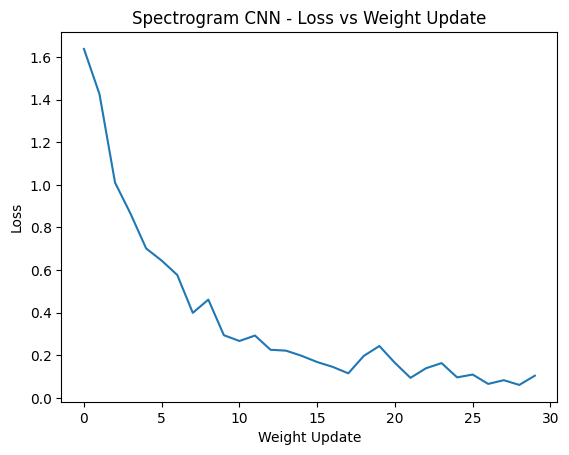

In [22]:
plt.plot(train_per_weight_update_spec)
plt.title("Spectrogram CNN - Loss vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.show()

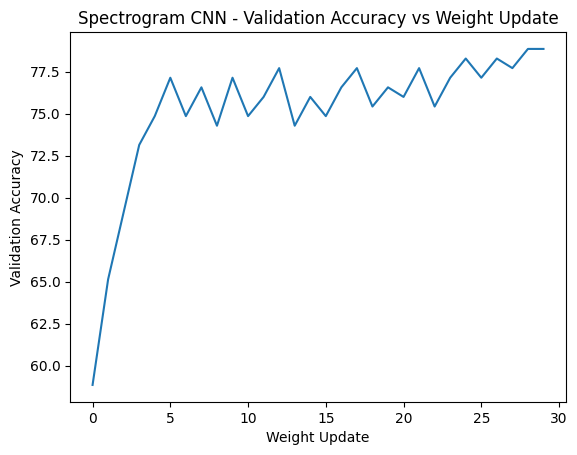

In [21]:
plt.plot(val_accu_lst_spec)
plt.title("Spectrogram CNN - Validation Accuracy vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Validation Accuracy")
plt.show()

### Training MFCC CNN

In [18]:
train_per_weight_update_mfcc, val_accu_lst_mfcc = train(
    model_mfcc,
    train_loader_mfcc,
    test_loader_mfcc,
    num_epochs,
    criterion,
    mfcc_model_save_path,
    learning_rate=0.005
)

Epoch: [1/30], Validation Accuracy: 54.2857
Epoch: [2/30], Validation Accuracy: 58.8571
Epoch: [3/30], Validation Accuracy: 65.1429
Epoch: [4/30], Validation Accuracy: 65.1429
Epoch: [5/30], Validation Accuracy: 66.8571
Epoch: [6/30], Validation Accuracy: 64.5714
Epoch: [7/30], Validation Accuracy: 72.0000
Epoch: [8/30], Validation Accuracy: 76.0000
Epoch: [9/30], Validation Accuracy: 75.4286
Epoch: [10/30], Validation Accuracy: 74.8571
Epoch: [11/30], Validation Accuracy: 75.4286
Epoch: [12/30], Validation Accuracy: 75.4286
Epoch: [13/30], Validation Accuracy: 61.1429
Epoch: [14/30], Validation Accuracy: 74.8571
Epoch: [15/30], Validation Accuracy: 77.1429
Epoch: [16/30], Validation Accuracy: 74.8571
Epoch: [17/30], Validation Accuracy: 76.5714
Epoch: [18/30], Validation Accuracy: 76.5714
Epoch: [19/30], Validation Accuracy: 78.8571
Epoch: [20/30], Validation Accuracy: 73.1429
Epoch: [21/30], Validation Accuracy: 80.0000
Epoch: [22/30], Validation Accuracy: 76.0000
Epoch: [23/30], Val

### Evaluating MFCC CNN

Plot MFCC and Spectrogram VGG loss and validation Accuracy

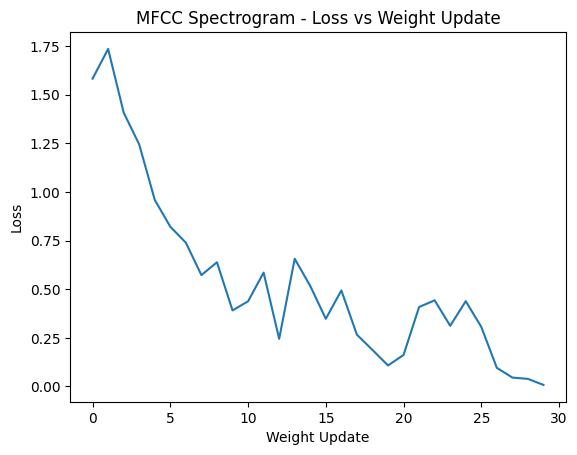

In [23]:
plt.plot(train_per_weight_update_mfcc)
plt.title("MFCC Spectrogram - Loss vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.show()

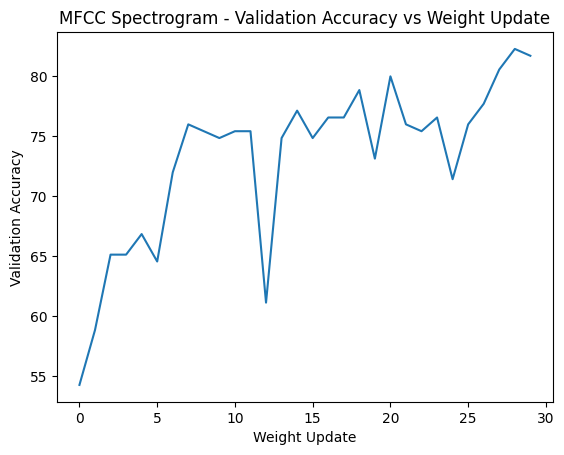

In [24]:
plt.plot(val_accu_lst_mfcc)
plt.title("MFCC Spectrogram - Validation Accuracy vs Weight Update")
plt.xlabel("Weight Update")
plt.ylabel("Validation Accuracy")
plt.show()